In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
attempts = pd.read_csv("/Users/borismartinez/Documents/GitHub/engage/data/vr_blocks_export.csv")
matches = pd.read_csv("/Users/borismartinez/Documents/GitHub/engage/data/vr_match_export.csv")

pledges = pd.read_csv("/Users/borismartinez/Documents/GitHub/engage/data/pledge_data.csv")


attempts.rename(columns={"upload_time": "a_date", "registration_form_id": "rf_id"}, inplace=True)
matches.rename(columns={"created_at": "m_date", "registration_form_id": "rf_id"}, inplace=True)

before = len(attempts)


/var/folders/h3/qc0834sx6gjb7174_439hbkc0000gn/T/ipykernel_88115/2478992146.py:2: DtypeWarning: Columns (5,14,15,16,17,18,22,25,32,36,64) have mixed types. Specify dtype option on import or set low_memory=False.
  attempts = pd.read_csv("/Users/borismartinez/Documents/GitHub/engage/data/vr_blocks_export.csv")


In [85]:
for col in attempts.columns:
    print(col)

a_date
voter_registration_scan_updated_at
visual_qc_county
is_registration_form
rf_id
registration_type
first_name
middle_name
last_name
name_suffix
voting_street_address_one
voting_street_address_two
voting_city
voting_state
voting_zipcode
mailing_street_address_one
mailing_street_address_two
mailing_city
mailing_zipcode
data_entry_county
gender
date_of_birth
identification
phone_number
email_address
eligible_voting_age
signature
extras
data_entry_time
data_entry_updated_at
party
name_prefix
ethnicity
voting_address_latitude
voting_address_longitude
distance_from_location
address_validated
shift_id
shift_start
shift_end
field_start
field_end
visual_qc_completed_by_user_id
phone_verification_completed_by_user_id
through_visual_qc
has_phone_number_visual_qc
qc_organization
packet_filename
qc_deadline
shift_delivered
canvasser_id
canvasser_first_name
canvasser_last_name
turf_id
name
van_committee_id
organization_name
collective_name
program_state
collection_location_id
collection_locatio

In [15]:
# Columns (5,14,15,16,17,18,22,25,32,36,64) have mixed types. Specify dtype option on import or set low_memory=False
cols_to_keep = [5, 14, 15, 16, 17, 18, 22, 25, 32, 36, 64]
df_subset = attempts.iloc[:, cols_to_keep]

In [ ]:
# Convert date columns
attempts["a_date"] = (
    pd.to_datetime(
        attempts["a_date"].astype(str).str.slice(0, 19),  # keep only YYYY-MM-DD HH:MM:SS
        errors="coerce",
        infer_datetime_format=True
    )
)
matches["m_date"] = pd.to_datetime(matches["m_date"], errors="coerce")


/var/folders/h3/qc0834sx6gjb7174_439hbkc0000gn/T/ipykernel_81416/3451627504.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.to_datetime(


In [47]:
# Keep only rf_ids that appear in both datasets
matched_inner = pd.merge(
    attempts,            # your vr_blocks_export data
    matches,             # your vr_match_export data
    on="rf_id",          # common unique ID
    how="inner",         # only keep rows with rf_id in both
    suffixes=("_attempt", "_match")  # distinguish same-named columns
)

In [67]:
# 1. build monthly counts from the two tables
monthly_counts_a = (
    attempts
    .groupby(attempts["a_date"].dt.to_period("M"))
    .size()
    .reset_index(name="attempts")
)

monthly_counts_m = (
    matches
    .groupby(matches["m_date"].dt.to_period("M"))
    .size()
    .reset_index(name="matches")
)

# 2. merge them on the period
monthly = (
    pd.merge(
        monthly_counts_a,
        monthly_counts_m,
        left_on="a_date",
        right_on="m_date",
        how="outer"
    )
    .drop(columns=["m_date"])
    .rename(columns={"a_date": "period"})
    .fillna(0)
)

# 3. make a real datetime column for plotting
monthly = (
    pd.merge(
        monthly_counts_a,
        monthly_counts_m,
        left_on="a_date",
        right_on="m_date",
        how="outer"
    )
    .rename(columns={"a_date": "period"})
    .drop(columns=["m_date"])
)

monthly["attempts"] = monthly["attempts"].fillna(0)
monthly["matches"] = monthly["matches"].fillna(0)

# Convert only non-null period entries to pandas Period dtype
monthly.loc[monthly["period"].notnull(), "period"] = monthly.loc[monthly["period"].notnull(), "period"].astype("period[M]")

# Create a timestamp column safely from Periods (NaT for missing)
monthly["period_start"] = monthly["period"].apply(lambda p: p.to_timestamp() if pd.notnull(p) else pd.NaT)

monthly["match_rate"] = np.where(
    monthly["attempts"] > 0,
    monthly["matches"] / monthly["attempts"],
    np.nan
)

In [77]:
pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [81]:
monthly_counts_a


,a_date,attempts
0,2018-04,4
1,2018-05,53
2,2018-06,343
3,2018-07,662
4,2018-08,135
5,2018-09,101
6,2018-10,5670
7,2019-07,4
8,2019-08,612
9,2019-09,1292


In [82]:
monthly_counts_m


,m_date,matches
0,2018-08,2069
1,2018-09,227
2,2018-10,3511
3,2019-03,94


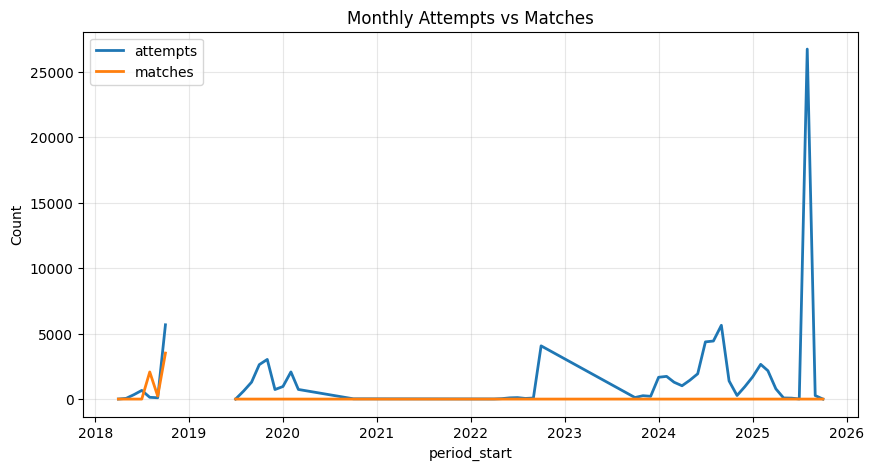

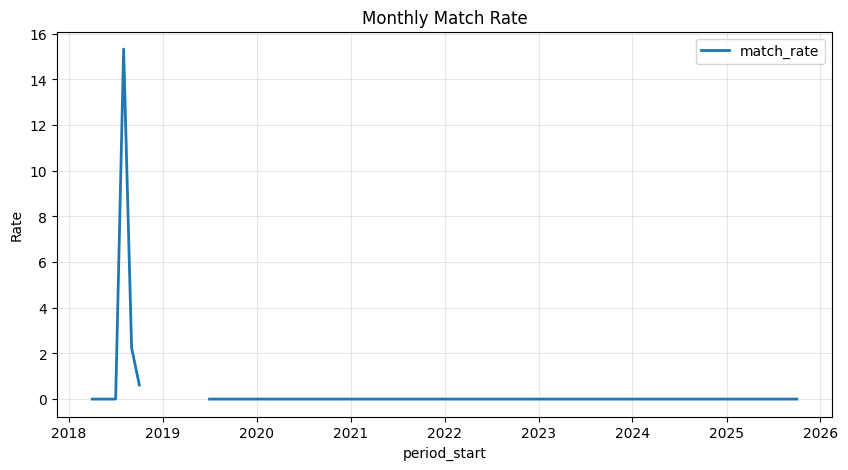

In [83]:
import matplotlib.pyplot as plt

def ts_line(df, x, ys, title="", ylabel=""):
    plt.figure(figsize=(10,5))
    for y in (ys if isinstance(ys, (list, tuple)) else [ys]):
        plt.plot(df[x], df[y], label=y, lw=2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

ts_line(monthly, "period_start", ["attempts", "matches"],
        title="Monthly Attempts vs Matches", ylabel="Count")

ts_line(monthly, "period_start", "match_rate",
        title="Monthly Match Rate", ylabel="Rate")